In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
import pandas as pd

## Define and Collect Trajectories of the Nonlinear System

In [2]:
def nonlinear_system(t,X):
    
    # specify rate of change of each state
    dx1dt = X[0]**2
    
    # roll up states into a numpy array
    dXdt = np.asarray([dx1dt])
    
    return dXdt

In [13]:
# initial condition
initial_state = [0.01]
dt = 0.01
final_time = 80
t_vec = np.arange(0,final_time,dt)
tspan = np.asarray([0,final_time])

states = solve_ivp(nonlinear_system, tspan, initial_state, t_eval = t_vec, method = "DOP853")

t = states.t
x = states.y
X = x[0,:]

(8000,) (8000,)


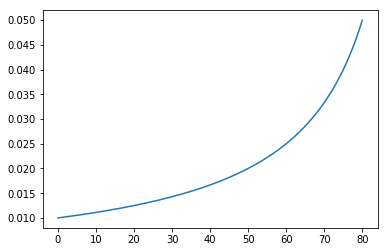

In [15]:
# plot trajectories
plt.plot(t,X)
print(t.shape,X.shape)

## Perform DMD with and without Time Delay Embeddings and Visualize Mode Spectrum

In [33]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b, Atilde

(1000, 7000)


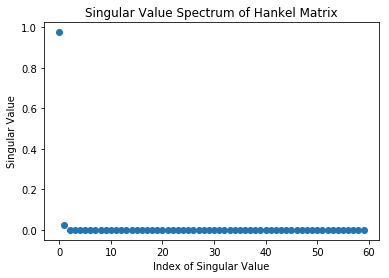

In [34]:
# time delay embedding

## Eigen-time delay coordinates
stackmax = 1000 # Number of shift-stacked rows
r = 60  # rank of HAVOK model
num_states = 1
H = np.zeros((stackmax,X.shape[0]-stackmax))

for k in range(0,stackmax,1):
    H[k,:] = X[k:-(stackmax-k)]
    
U,S,VT = np.linalg.svd(H,full_matrices=0)
V = VT.T

S = S[:r]

plt.plot(S/np.sum(S),'o')
plt.title('Singular Value Spectrum of Hankel Matrix')
plt.ylabel('Singular Value')
plt.xlabel('Index of Singular Value')
print(H.shape)


In [35]:
latent_vars = np.where(S>1)[0]
print(latent_vars)
print(H.shape)

[0 1]
(1000, 7000)


In [36]:
S

array([5.47457005e+01, 1.36561827e+00, 2.86337702e-02, 4.75909085e-04,
       8.62818592e-05, 8.46822671e-06, 3.79632275e-06, 1.61969282e-06,
       8.87783904e-07, 4.93899309e-07, 3.08902794e-07, 1.96940541e-07,
       1.34297955e-07, 9.31069784e-08, 6.75004167e-08, 4.95944868e-08,
       3.75843288e-08, 2.87944671e-08, 2.25853278e-08, 1.78738138e-08,
       1.43976911e-08, 1.16848625e-08, 9.62102919e-09, 7.97203177e-09,
       6.68130795e-09, 5.63035250e-09, 4.79088564e-09, 4.09592557e-09,
       3.52967575e-09, 3.05443036e-09, 2.66157564e-09, 2.32768647e-09,
       2.04775997e-09, 1.80729362e-09, 1.60349329e-09, 1.42664114e-09,
       1.27526135e-09, 1.14273996e-09, 1.02832101e-09, 9.27312815e-10,
       8.39497116e-10, 7.61405859e-10, 6.93004035e-10, 6.31760525e-10,
       5.77847381e-10, 5.29292306e-10, 4.86244135e-10, 4.47271853e-10,
       4.12581428e-10, 3.81037481e-10, 3.52757350e-10, 3.26948836e-10,
       3.03727705e-10, 2.82471277e-10, 2.63207141e-10, 2.45531429e-10,
      

In [40]:
# create the X and Xprime matrices of the dimelayed embeddings to pass to the DMD function
X_delay_prime = H[:,1:]
X_delay = H[:,:-1]

print(X_delay.shape,X_delay_prime.shape)
# obtain Time Delayed DMD model
r = 10 # enter the value of r
Phi_delay, Lambda_delay, b_delay, A = DMD(X_delay,X_delay_prime,r)
omega_delay = np.log(np.diag(Lambda_delay))/dt

print('Phi =',Phi_delay,'\n')
print('Lambda =',Lambda_delay,'\n')
print('b = ',b_delay,'\n')
print('Omega =',omega_delay,'\n')
print('A = ', A)

(1000, 6999) (1000, 6999)
Phi = [[ 0.00561502-0.03056871j  0.00561502+0.03056871j -0.02788564-0.01492139j
  ...  0.02431133+0.j         -0.03025692+0.j
   0.03512026+0.j        ]
 [ 0.00627086-0.03042784j  0.00627086+0.03042784j -0.02771387-0.01524619j
  ...  0.02432319+0.j         -0.03025956+0.j
   0.0351126 +0.j        ]
 [ 0.00691727-0.03027766j  0.00691727+0.03027766j -0.02753889-0.01556791j
  ...  0.02433506+0.j         -0.0302622 +0.j
   0.03510493+0.j        ]
 ...
 [-0.01920987-0.02397226j -0.01920987+0.02397226j -0.01550234+0.0275589j
  ...  0.03954499+0.j         -0.03300835+0.j
   0.0282485 +0.j        ]
 [-0.01867014-0.02434402j -0.01867014+0.02434402j -0.01580606+0.02736805j
  ...  0.03956429+0.j         -0.03301124+0.j
   0.02824233+0.j        ]
 [-0.01811589-0.02470848j -0.01811589+0.02470848j -0.01610768+0.02717247j
  ...  0.0395836 +0.j         -0.03301412+0.j
   0.02823616+0.j        ]] 

Lambda = [[0.99982164+0.0180829j  0.        +0.j         0.        +0.j
  0.   

In [47]:
ind = np.where(A<1e-3)
A[ind] = 0
A_pd = pd.DataFrame(data = A)
A_pd.head(19)

,0,1,2,3,4,5,6,7,8,9
0,1.000259,0.000000,0.001170,0.000000,0.001533,0.000000,0.000000,0.000000,0.000000,0.005702
1,0.000000,1.000782,0.000000,0.001118,0.000000,0.001329,0.000000,0.001435,0.000000,0.000000
2,0.000000,0.000000,1.001293,0.000000,0.003393,0.000000,0.001825,0.000000,0.001904,0.012666
3,0.000000,0.000000,0.000000,0.999890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.002088,0.000000,0.002128,0.000000,0.002257,0.016543
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.999938,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.003775,1.000024,0.000000,0.000000,0.015583
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003408,0.999881,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006684,0.999882,0.022586
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999766


In [38]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics_delay = np.zeros([r,X_delay.shape[1]])

for i in range(time_dynamics_delay.shape[1]):
    time_dynamics_delay[:,i] = b_delay*np.exp(omega_delay*t_vec[i])
    
X_dmd_delay = np.dot(Phi_delay,time_dynamics_delay)

print(time_dynamics_delay.shape,Phi_delay.shape,X_dmd_delay.shape)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


(10, 6999) (1000, 10) (1000, 6999)


In [39]:
time_dynamics_delay.shape[1]

6999

/home/ashwin/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


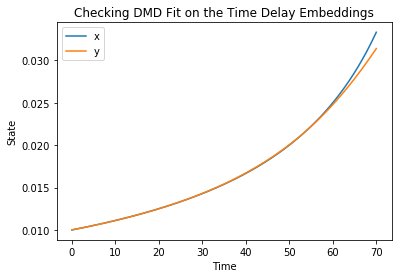

In [84]:
X_dmd_delay_model = X_dmd_delay[:,:]

# plot to compare the DMD modes to the actual data
end_delay = X_dmd_delay_model.shape[1]
t_delay = t[:end_delay]
plt.plot(t_delay,X[:end_delay],label='x')
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

print()

## Reconstruct Using Koopman Triplet

In [101]:
rank = 5
K = np.zeros([rank,rank])
for i in range(rank-1):
    K[i,i+1] = i+1
    
# define the eigenfucntion
n = 1000
lamb = np.arange(1,n+1)
eigen_func = np.asarray([ np.exp(-lamb[i-1]/X) for i in lamb ])

eig_forecast = np.sum(eigen_func,axis = 0)

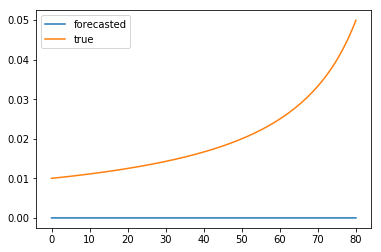

In [102]:
plt.plot(t,eig_forecast,label = 'forecasted')
plt.plot(t,X,label = 'true')
plt.legend()